# **IMDb Movie Reviews Sentiment Analysis Task**


### **Dataset Description**

The IMDb 50K Movie Reviews dataset is a widely used benchmark for sentiment analysis tasks. It consists of 50,000 movie reviews from the Internet Movie Database (IMDb), labeled as positive or negative.

The dataset is balanced, containing an equal number of positive and negative reviews, ensuring a fair evaluation of sentiment classification models. This dataset is instrumental in natural language processing (NLP) research, particularly in text classification and sentiment analysis

The dataset can be downloaded from [Kaggle](https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews)

#### **About the Notebook**

This notebook contains the **Exploratory Data Analysis (EDA)** of the IMDb dataset, **preprocessing steps** taken for the traditional Machine Learning models and the Deep Learning models, and the **model architectures**, **training** and **evaluation** of the traditional Machine Learning models and the Deep Learning models.

## **Exploratory Data Analysis (EDA)**

In [ ]:
!pip install kaggle


In [ ]:
import os
import json

# Upload your kaggle.json (you get this from your Kaggle account settings)
from google.colab import files
files.upload()  # Select kaggle.json

# Move it to the right place
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/
os.chmod('/root/.kaggle/kaggle.json', 600)


Saving kaggle.json to kaggle.json


In [ ]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
!mkdir '/content/data'
!unzip -qo 'imdb-dataset-of-50k-movie-reviews.zip' -d '/content/data'

mkdir: cannot create directory ‘/root/.kaggle’: File exists
cp: cannot stat 'kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews
License(s): other
  0% 0.00/25.7M [00:00<?, ?B/s]
100% 25.7M/25.7M [00:00<00:00, 1.32GB/s]
mkdir: cannot create directory ‘/content/data’: File exists


#### **Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from wordcloud import WordCloud
from bs4 import BeautifulSoup
import tensorflow as tf
import re
import nltk
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
!pip install contractions
from contractions import fix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer, accuracy_score, f1_score, classification_report, confusion_matrix

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# Load data
df = pd.read_csv('/content/data/IMDB Dataset.csv')

df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df = pd.read_csv('IMDB Dataset.csv')

In [ ]:
df = pd.read_csv('/content/IMDB Dataset.csv')

In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB
None


In [ ]:
print(df.describe())

                                                   review sentiment
count                                               50000     50000
unique                                              49582         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     25000


## **EDA Process**

In [ ]:
#Checking duplicates and handle them
print(df.duplicated().sum())

418


In [ ]:
#Handling them
df.drop_duplicates(inplace=True)

print(df.duplicated().sum())


0


<Axes: xlabel='sentiment', ylabel='count'>

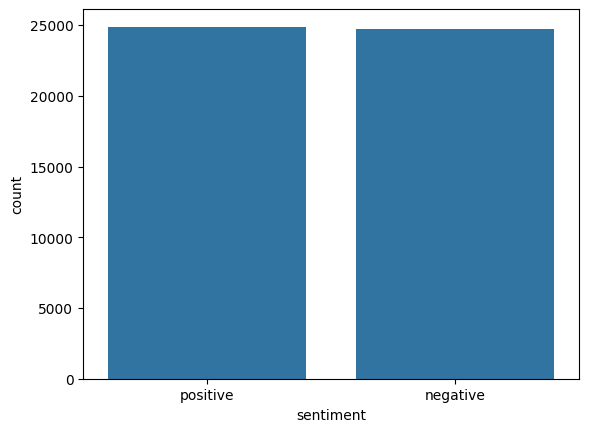

In [ ]:
#Class Distribution check
sns.countplot(x='sentiment', data=df)

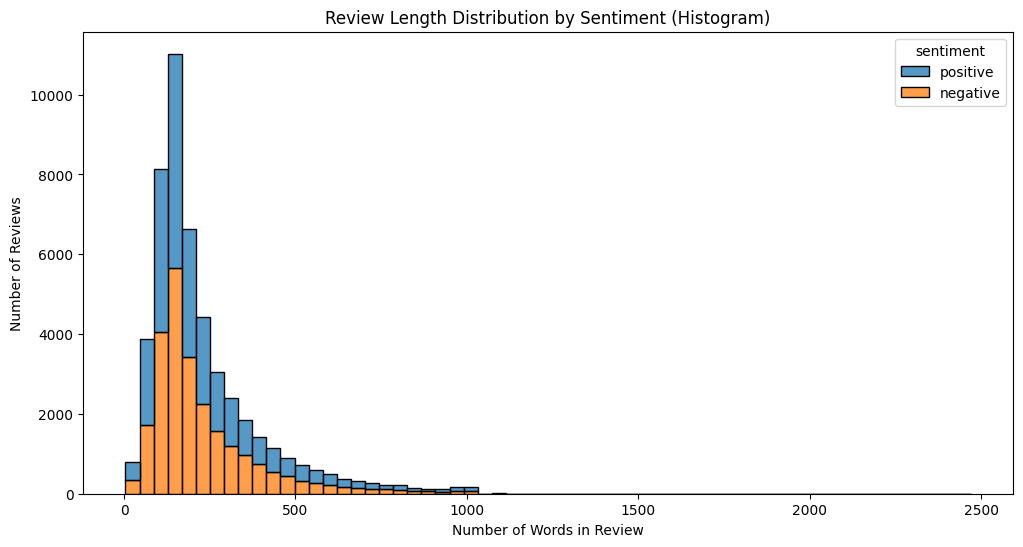

In [ ]:
# Compare review length across sentiment
df['review_length'] = df['review'].apply(lambda x: len(x.split()))
df['review_length'].describe()


plt.figure(figsize=(12,6))
sns.histplot(data=df, x='review_length', hue='sentiment', bins=60, kde=False, multiple='stack')
plt.title("Review Length Distribution by Sentiment (Histogram)")
plt.xlabel("Number of Words in Review")
plt.ylabel("Number of Reviews")
plt.show()

**Class distribution analysis**

- to check the target(sentiment) distribution

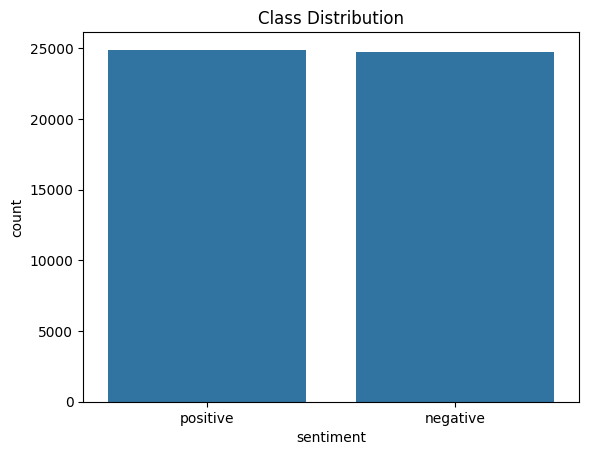

In [ ]:
sns.countplot(x='sentiment', data=df)
plt.title('Class Distribution')
plt.show()

## **Data Preprocessing**

### **Data Preprocessing for Traditional Machine Learning Models**

Preprocessing for the traditional machine learning models was handled differently from that of the deep learning models. The preprocessing here was more aggressive, especially with text cleaning.

The preprocessing steps were implemented to make sure that they are customized for our sentiment analysis task.

Here are the steps that were taken:

1. HTML and special character handling

2. Contraction expansion

3. Lowercasing + Stopword filtering with a custom keeplist (on keeping sentiment-heavy words like not, but)

4. Lemmatization

5. Negation handling with not_ + word combos — that's a great trick that helps traditional models "feel" polarity

In [ ]:
nltk.download('punkt_tab')

# Initialize stopwords with custom keeplist
STOPWORDS = set(stopwords.words('english'))
KEEP_WORDS = {'not', 'no', 'but', 'very', 'too', 'just', 'only', 'nor'}
STOPWORDS = STOPWORDS - KEEP_WORDS

lemmatizer = WordNetLemmatizer()

def ml_preprocess(text):
  # remove HTML tags
  text = re.sub(r'<[^>]+>', '', text)
  # handle special characters and numbers
  text = re.sub(r'[^a-zA-Z\s!?]', '', text)
  # expand contractions
  text = fix(text)
  # lowercasing
  text = text.lower()
  # tokenize with custom stopwrod remover
  tokens = [word for word in word_tokenize(text)
            if word not in STOPWORDS]
  # lemmatization
  tokens = [lemmatizer.lemmatize(word) for word in tokens]
  # handle negations (eg, 'not good' - 'not_good')
  processed = []
  for i, word in enumerate(tokens):
    if word in ['not', 'no'] and i+1 < len(tokens):
      # Append the combined negation and subsequent word
      processed.append(f"{word}_{tokens[i+1]}")
      # Skip the next word since it's already processed with the negation
      tokens[i+1] = None # Mark as None to skip in the next iteration
    elif word is not None: # Only process if the word hasn't been skipped
      processed.append(word)

  return ' '.join(processed)


df['ml_processed'] = df['review'].apply(ml_preprocess)

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


#### **Feature Engineering**

Steps taken:
1. Data splitting before engineering to avoid data leakage

2. Added 'stratify' to maintain class balance

3. Safe vectorization

  - 'fit_transform()' only on training data - learns the vocabulary and document frequencies
  - 'transform() on test data (no fitting) - applies these learned stats

  why?

  to avoid data leakage - test data should never influence feature creation


In [ ]:
# train-test split to avoid leakage
train_df, test_df = train_test_split(
    df,
    test_size=0.2,
    random_state=42,
    stratify=df['sentiment'] # for class balance
)

# vectorization
tfidf = TfidfVectorizer(
    ngram_range=(1, 3),
    max_features=15000,
    min_df=5,
    max_df=0.7,
    stop_words=list(STOPWORDS)
)

# Fit and transform training data
X_train = tfidf.fit_transform(train_df['ml_processed'])
# Transform test data (no fitting!)
X_test = tfidf.transform(test_df['ml_processed'])

# Convert labels to numeric
y_train = train_df['sentiment'].map({'positive': 1, 'negative': 0})
y_test = test_df['sentiment'].map({'positive': 1, 'negative': 0})

## **Logistic Regression and SVM Model Architectures and Training**


Logistic Regression Results:
Accuracy: 0.8940
F1 Score: 0.8956

Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.88      0.89      4940
           1       0.89      0.91      0.90      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



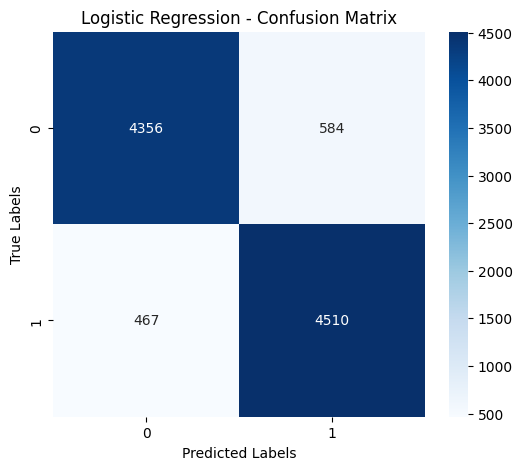


SVM Results:
Accuracy: 0.8904
F1 Score: 0.8931

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.87      0.89      4940
           1       0.87      0.91      0.89      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



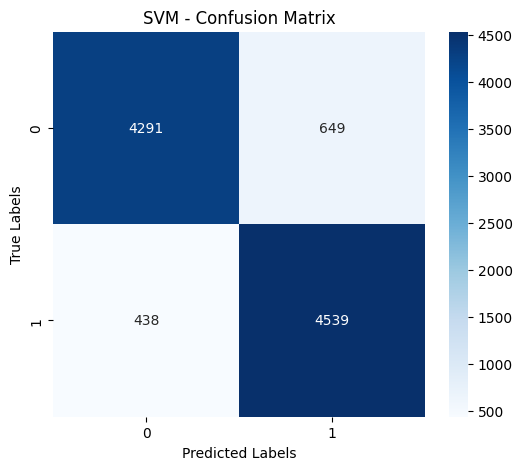

In [ ]:
# Model training
models = {
    "Logistic Regression": LogisticRegression(
        max_iter=1000,
        C=0.5,
        class_weight='balanced',
        random_state=42
    ),
    "SVM": SVC(
        kernel='linear',
        C=0.1,
        class_weight='balanced',
        random_state=42
    )
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)  # train
    y_pred = model.predict(X_test)  # predict

    # evaluate
    results[name] = {
        'accuracy': accuracy_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'classification_report': classification_report(y_test, y_pred),
        'confusion_matrix': confusion_matrix(y_test, y_pred)
    }

# Results & Visualization
for model_name, metrics in results.items():
    print(f"\n{model_name} Results:")
    print(f"Accuracy: {metrics['accuracy']:.4f}")
    print(f"F1 Score: {metrics['f1']:.4f}")
    print("\nClassification Report:")
    print(metrics['classification_report'])

    # Confusion matrix visualization
    plt.figure(figsize=(6, 5))
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', cmap='Blues')
    plt.title(f"{model_name} - Confusion Matrix")
    plt.xlabel("Predicted Labels")
    plt.ylabel("True Labels")
    plt.show()


In [ ]:
# Compare with cross-validation (on training set only)
from sklearn.model_selection import cross_val_score
print("\nCross-validation scores (on training data):")
for name, model in models.items():
    cv_scores = cross_val_score(
        model, X_train, y_train, cv=5, scoring='f1', n_jobs=-1
    )
    print(f"{name} CV F1: {cv_scores.mean():.4f} (±{cv_scores.std():.4f})")


Cross-validation scores (on training data):
Logistic Regression CV F1: 0.8935 (±0.0025)
SVM CV F1: 0.8905 (±0.0016)


# **Deep Learning Preprocessing**


In [ ]:
#make a copy for df
df_copy = df.copy()

df_copy.head()

,review,sentiment,review_length,ml_processed
0,One of the other reviewers has mentioned that ...,positive,307,one reviewer mentioned watching just oz episod...
1,A wonderful little production. <br /><br />The...,positive,162,wonderful little production filming technique ...
2,I thought this was a wonderful way to spend ti...,positive,166,thought wonderful way spend time too hot summe...
3,Basically there's a family where a little boy ...,negative,138,basically family little boy jake think zombie ...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,230,petter matteis love time money visually stunni...


In [ ]:
from nltk import pos_tag
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from bs4 import BeautifulSoup
import contractions
from nltk.corpus import wordnet

# Ensure necessary resources
try:
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('wordnet')
try:
    nltk.data.find('tokenizers/punkt')
except LookupError:
    nltk.download('punkt')
try:
    nltk.data.find('corpora/stopwords')
except LookupError:
    nltk.download('stopwords')
try:
    nltk.data.find('taggers/averaged_perceptron_tagger_eng') # Ensure English tagger
except LookupError:
    nltk.download('averaged_perceptron_tagger_eng')

try:
    nltk.data.find('tokenizers/punkt_tab')
except LookupError:
    nltk.download('punkt_tab')


# Stopwords setup with important negations kept
stop_words = set(stopwords.words('english'))
negation_words = {"not", "no", "nor", 'but', 'very', 'too', 'just', 'only'}

stop_words = stop_words.difference(negation_words)

# POS tag converter
def get_wordnet_pos(tag):
    """Maps NLTK POS tags to WordNet POS tags."""
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        # Default to noun if no clear match, though might not be ideal for all words
        return wordnet.NOUN

# Final DL preprocessing function
def preprocess_for_dl(df, max_len=300, num_words=20000):
    lemmatizer = WordNetLemmatizer()
    cleaned_reviews = []

    for text in df['review']:
        # Remove HTML tags
        soup = BeautifulSoup(text, "html.parser")
        text = soup.get_text()

        # Lowercase
        text = text.lower()

        # Expand contractions using the library
        text = contractions.fix(text)

        # Remove special characters, digits, and extra whitespace
        text = re.sub(r"[^a-zA-Z\s]", " ", text)
        text = re.sub(r"\s+", " ", text).strip()

        # Tokenize
        tokens = word_tokenize(text)

        # POS tag
        pos_tags = pos_tag(tokens)

        lemmatized_tokens = []
        # Lemmatize with POS and then remove stop words
        for word, tag in pos_tags:
            # Get the WordNet POS tag
            wn_tag = get_wordnet_pos(tag)
            # Lemmatize the word
            lemma = lemmatizer.lemmatize(word, wn_tag)
            # Append the lemma if it is not a stop word and is not just whitespace
            if lemma not in stop_words and lemma.strip() != '':
                 lemmatized_tokens.append(lemma)


        cleaned_reviews.append(" ".join(lemmatized_tokens))

    # Save cleaned column (optional, but good for inspection)
    df['clean_review'] = cleaned_reviews

    # Prepare for model
    texts = df['clean_review'].values
    labels = df['sentiment'].map({'positive': 1, 'negative': 0}).values

    # Keras tokenization
    tokenizer = Tokenizer(num_words=num_words, oov_token="<OOV>")
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)

    # Padding
    X_dl = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')
    y_dl = np.array(labels)

    return X_dl, y_dl, tokenizer, df


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


In [ ]:
# Run the preprocessing
X_dl, y_dl, tokenizer, df_cleaned = preprocess_for_dl(df_copy)

# Check outputs
print("Preprocessing complete!")
print("-" * 50)

# Shape of processed data
print(f"Shape of X_dl (padded sequences): {X_dl.shape}")
print(f"Shape of y_dl (labels): {y_dl.shape}")
print("-" * 50)

# Preview tokenized and padded sequence of first review
print("Example tokenized & padded sequence (first review):")
print(X_dl[0])
print("-" * 50)

# Preview original vs cleaned review
print("Original review:")
print(df['review'].iloc[0])
print("\nCleaned review:")
print(df_cleaned['clean_review'].iloc[0])
print("-" * 50)

# Preview tokenizer vocab size
print(f"Tokenizer vocabulary size: {len(tokenizer.word_index)} (limited to top {tokenizer.num_words} words)")


Preprocessing complete!
--------------------------------------------------
Shape of X_dl (padded sequences): (49582, 300)
Shape of y_dl (labels): (49582,)
--------------------------------------------------
Example tokenized & padded sequence (first review):
[    6  1023   331    18    12  2616   183  1593   112   508   114    38
    44  1131  2616  4404 12049    28   464   109   112   268    16  1304
     2    27  4901  1981  9266    27   539    21  1600  1034   557   289
   464  3203   230    70   268   160  2616  6690    39 12050  5637  2165
   472     1   545  1225 17705   397  3854  1812   981  1786  1680   800
   195     1 13260     2   175  3691   397   253    54 11623  3484     1
     1  1138   835  2080     1   209  3944  6046  8909  6937  6691    57
   118   158    14    32   193   784    27   562   102    16    27    14
     2  1594   407   105   254  1280  2123   171   407   717   407   678
  2616     2   666   107    38   183    61   132  1131  1332  1912    35
     2    32

In [ ]:
# Split data into training and testing sets
from sklearn.model_selection import train_test_split

X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_dl, y_dl, test_size=0.2, random_state=42, stratify=y_dl
)

# Check the shapes of the split data
print("Shape of X_train_dl:", X_train_dl.shape)
print("Shape of X_test_dl:", X_test_dl.shape)
print("Shape of y_train_dl:", y_train_dl.shape)
print("Shape of y_test_dl:", y_test_dl.shape)


Shape of X_train_dl: (39665, 300)
Shape of X_test_dl: (9917, 300)
Shape of y_train_dl: (39665,)
Shape of y_test_dl: (9917,)


## **Kenny Kevin's Model, Glove & Attention Mechanism**

Used Glove and attention mechanism and simple lstm with one lstm layer 2 dropouts layer 2 dense layers one is the output layer, 64 units on the lstm layer and 32 units on one of the dense layer, dropout of 0.3

In [ ]:
# Defining Glove loading
def load_glove_embeddings(glove_path, tokenizer, embedding_dim=100):
    embeddings_index = {}
    with open(glove_path, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = vector

    word_index = tokenizer.word_index
    num_words = min(len(word_index) + 1, 20000)
    embedding_matrix = np.zeros((num_words, embedding_dim))

    for word, i in word_index.items():
        if i < 20000:
            embedding_vector = embeddings_index.get(word)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix


In [ ]:
# Defining Attention layer
from tensorflow.keras.layers import Layer

class AttentionLayer(Layer):
    def __init__(self):
        super(AttentionLayer, self).__init__()

    def build(self, input_shape):
        self.W = self.add_weight(shape=(input_shape[-1], 1), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(input_shape[1], 1), initializer="zeros", trainable=True)

    def call(self, inputs):
        e = tf.nn.tanh(tf.matmul(inputs, self.W) + self.b)
        attention_weights = tf.nn.softmax(e, axis=1)
        context_vector = attention_weights * inputs
        context_vector = tf.reduce_sum(context_vector, axis=1)
        return context_vector


In [ ]:
# Defining my model architecture
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

def build_and_train_lstm_model_with_glove_attention(X_train, y_train, X_val, y_val,
                                                    tokenizer, embedding_matrix,
                                                    vocab_size=20000,
                                                    embedding_dim=100,
                                                    max_len=300,
                                                    units=64,
                                                    dense_units=32,
                                                    dropout=0.3,
                                                    batch_size=64,
                                                    epochs=10,
                                                    learning_rate=0.001):

    # Define model
    input_layer = Input(shape=(max_len,))
    embedding_layer = Embedding(input_dim=vocab_size,
                                output_dim=embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_len,
                                trainable=False)(input_layer)

    lstm_out = LSTM(units, return_sequences=True)(embedding_layer)
    attention_out = AttentionLayer()(lstm_out)

    x = Dropout(dropout)(attention_out)
    x = Dense(dense_units, activation='relu')(x)
    x = Dropout(dropout)(x)
    output = Dense(1, activation='sigmoid')(x)

    model = Model(inputs=input_layer, outputs=output)
    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    # Callbacks
    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

    # Train model
    history = model.fit(X_train, y_train,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=[early_stop],
                        verbose=1)
    # Plot training and validation loss
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

    return model, history


In [ ]:
# Applying embedding matrix
embedding_matrix = load_glove_embeddings("glove.6B.100d.txt", tokenizer)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 207s 327ms/step - accuracy: 0.6165 - loss: 0.6641 - val_accuracy: 0.7666 - val_loss: 0.4880
Epoch 2/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 261s 325ms/step - accuracy: 0.8024 - loss: 0.4450 - val_accuracy: 0.8403 - val_loss: 0.3658
Epoch 3/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 200s 323ms/step - accuracy: 0.8492 - loss: 0.3505 - val_accuracy: 0.8659 - val_loss: 0.3193
Epoch 4/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 199s 319ms/step - accuracy: 0.8693 - loss: 0.3171 - val_accuracy: 0.8712 - val_loss: 0.3080
Epoch 5/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 203s 320ms/step - accuracy: 0.8755 - loss: 0.3038 - val_accuracy: 0.8738 - val_loss: 0.2999
Epoch 6/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 208s 330ms/step - accuracy: 0.8828 - loss: 0.2823 - val_accuracy: 0.8839 - val_loss: 0.2862
Epoch 7/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 260s 327ms/step - accuracy: 0.8905 - loss: 0.2713 - val_accuracy: 0.8804 - val_loss: 0.2912
Epoch 8/10
620/620 ━━━━━━━━━━━━━━━━━━━━ 200s 322ms/step - accuracy: 0.8981 -

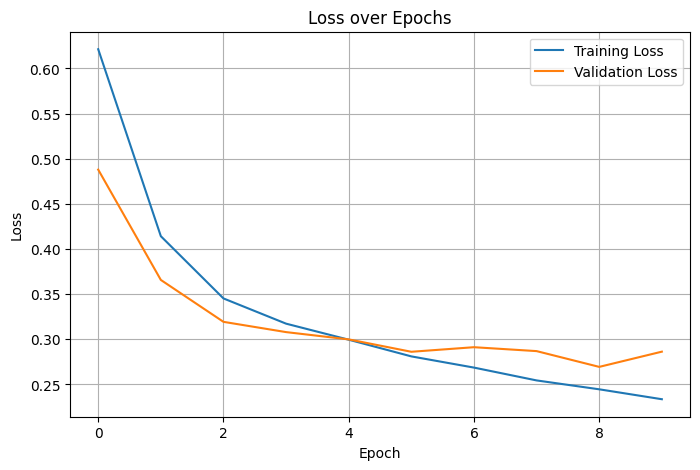

In [ ]:
model_kenny, history_kenny = build_and_train_lstm_model_with_glove_attention(
    X_train_dl, y_train_dl,
    X_test_dl, y_test_dl,
    tokenizer,
    embedding_matrix
)

In [ ]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

def predict_and_evaluate(model, X_test, y_test, threshold=0.5):
    # Get probability predictions
    y_pred_probs = model.predict(X_test, verbose=0)

    # Convert probabilities to binary labels
    y_pred_labels = (y_pred_probs >= threshold).astype(int)

    # Print metrics
    print("Classification Report:")
    print(classification_report(y_test, y_pred_labels))

    print("Confusion Matrix:")
    print(confusion_matrix(y_test, y_pred_labels))
    # Visualize confusion matrix
    cm = confusion_matrix(y_test, y_pred_labels)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
    plt.title("Confusion Matrix")
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.show()

    return y_pred_labels


Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.89      4940
           1       0.88      0.91      0.89      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917

Confusion Matrix:
[[4305  635]
 [ 471 4506]]


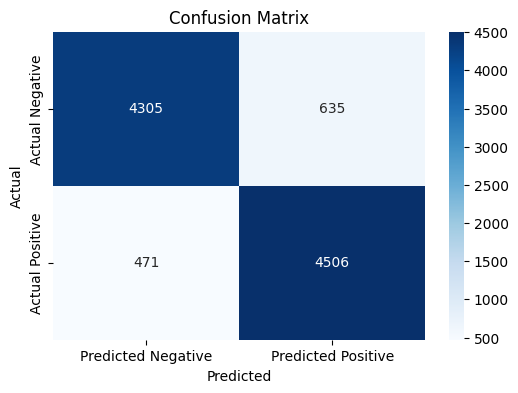

In [ ]:
y_pred = predict_and_evaluate(model_kenny, X_test_dl, y_test_dl)


## **Lindah Nyambura's Model - Bidirectional GRU**

This model is a Bidirectional GRU model using pre-trained GloVe embeddings.

**Embedding Layer**:
- Sequences of word indices (shape 300)
- Each index mapped to a 100D GloVe vector
- GloVe vector weights are frozen to preserve semantics

**Dropout Layer**:
- prevents overfitting by randomly disabling 30% of units during training

**Bidirectional GRU**:
- A GRU processes the sequences in both directions
- 32 units per direction - 64 total hidden dimensions
- Dropouts help regularize bith inputs and hidden state transitions

**Second Dropout**:
- Additional regularization before final dense layer

**Output Layer**:
- Outputs a probability of 0 or 1

**Compilation**:
- Adam optimizer
- clipnorm=1.0 to prevent exploding grdients
- tracks accuracy, precision, recall

**Callbacks**:
- EarlyStopping at patience 3
- ReduceLROnPlateau halves the learning rate if val_loss stagnates at 2 epochs

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dropout, Bidirectional, GRU, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
def build_glove_gru(VOCAB_SIZE=20000,
                    MAX_LEN=300,
                    embedding_dim=100
                    ):
    model = Sequential([
        Embedding(
            input_dim=VOCAB_SIZE,
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            input_length=MAX_LEN,
            trainable=False,
            mask_zero=True
        ),
        Dropout(0.3),  # Optional additional regularization
        Bidirectional(GRU(
            32,
            dropout=0.4,
            recurrent_dropout=0.3,
            return_sequences=False
        )),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001, clipnorm=1.0),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
    )
    return model


In [ ]:
# Download GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip -q glove.6B.zip

# Applying embedding matrix
embedding_matrix = load_glove_embeddings("glove.6B.100d.txt", tokenizer)

--2025-06-08 09:36:06--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2025-06-08 09:36:06--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2025-06-08 09:36:06--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [ ]:
callbacks = [
    # Stop early if validation loss doesn't improve
    EarlyStopping(
        monitor='val_loss',
        mode='min',
        patience=3,
        restore_best_weights=True,
        verbose=1
    ),

    # Reduce learning rate more aggressively
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=2,
        min_lr=1e-6,
        verbose=1
    )
]

model = build_glove_gru()
history = model.fit(
    X_train_dl, y_train_dl,
    epochs=12,
    batch_size=128,
    validation_split=0.2,
    callbacks=callbacks,
    verbose=1
)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/12
248/248 ━━━━━━━━━━━━━━━━━━━━ 226s 873ms/step - accuracy: 0.5398 - loss: 0.7235 - precision: 0.5447 - recall: 0.5531 - val_accuracy: 0.7133 - val_loss: 0.5668 - val_precision: 0.6942 - val_recall: 0.7654 - learning_rate: 0.0010
Epoch 2/12
248/248 ━━━━━━━━━━━━━━━━━━━━ 247s 813ms/step - accuracy: 0.6832 - loss: 0.5954 - precision: 0.6836 - recall: 0.7002 - val_accuracy: 0.7988 - val_loss: 0.4439 - val_precision: 0.7958 - val_recall: 0.8054 - learning_rate: 0.0010
Epoch 3/12
248/248 ━━━━━━━━━━━━━━━━━━━━ 211s 847ms/step - accuracy: 0.7444 - loss: 0.5241 - precision: 0.7434 - recall: 0.7436 - val_accuracy: 0.8128 - val_loss: 0.4173 - val_precision: 0.8164 - val_recall: 0.8084 - learning_rate: 0.0010
Epoch 4/12
248/248 ━━━━━━━━━━━━━━━━━━━━ 251s 806ms/step - accuracy: 0.7653 - loss: 0.4958 - precision: 0.7642 - recall: 0.7673 - val_accuracy: 0.8238 - val_loss: 0.4000 - val_precision: 0.7972 - val_recall: 0.8698 - learning_rate: 0.0010
Epoch 5/12
248/248 ━━━━━━━━━━━━━━━━━━━━ 210s 841

### **Model Evaluation**

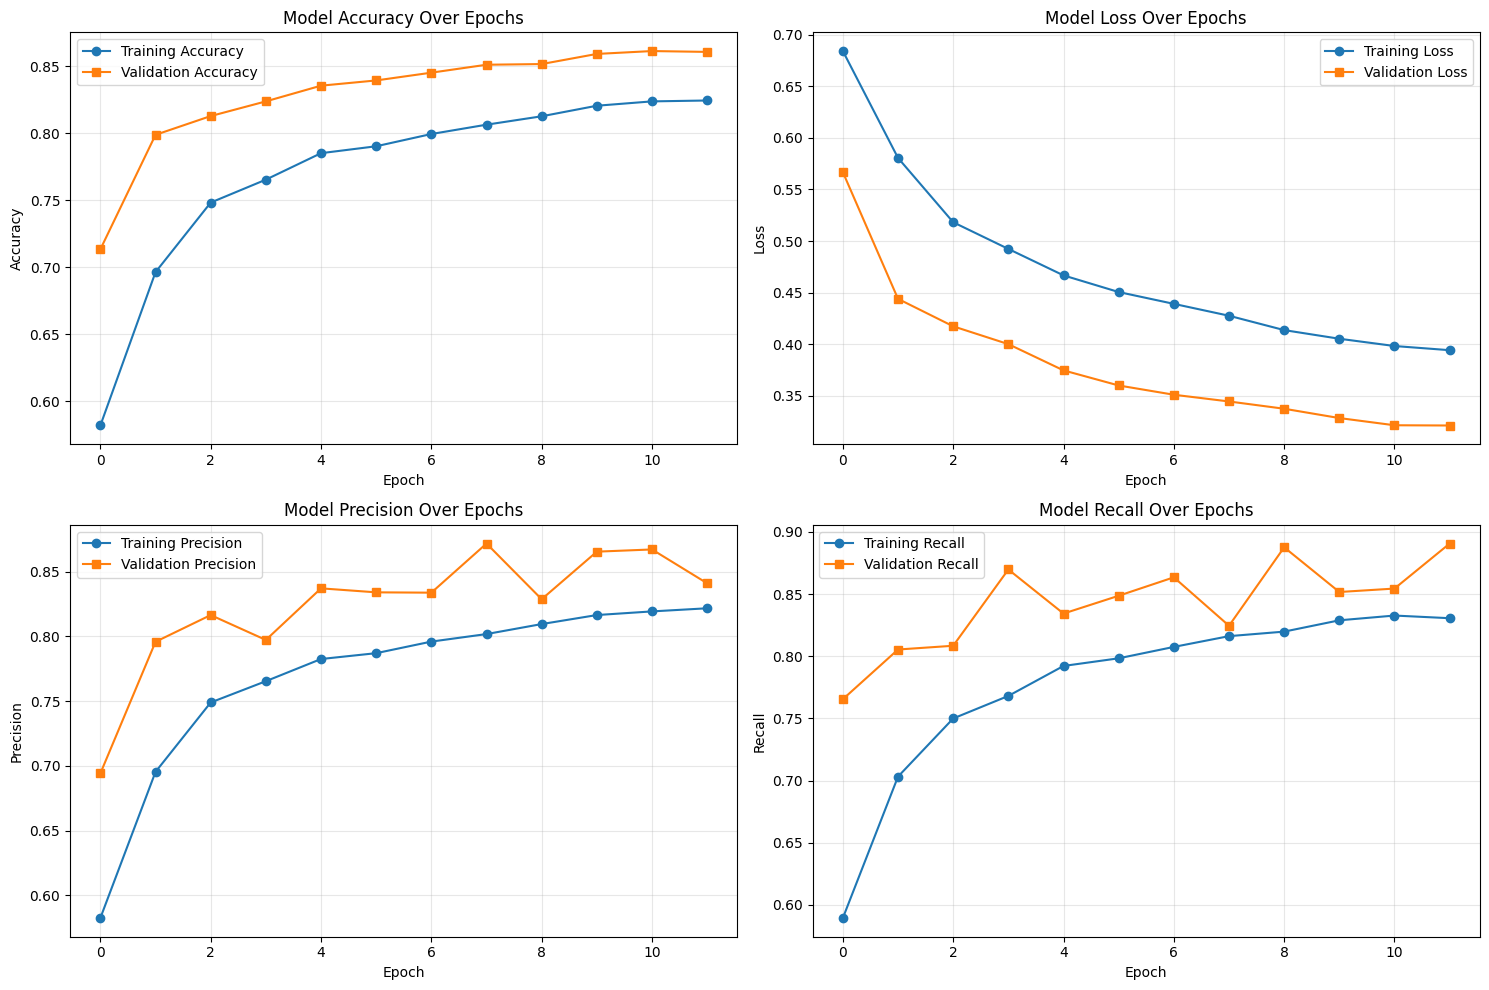

In [ ]:
def plot_training_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Accuracy
    axes[0,0].plot(history.history['accuracy'], label='Training Accuracy', marker='o')
    axes[0,0].plot(history.history['val_accuracy'], label='Validation Accuracy', marker='s')
    axes[0,0].set_title('Model Accuracy Over Epochs')
    axes[0,0].set_xlabel('Epoch')
    axes[0,0].set_ylabel('Accuracy')
    axes[0,0].legend()
    axes[0,0].grid(True, alpha=0.3)

    # Loss
    axes[0,1].plot(history.history['loss'], label='Training Loss', marker='o')
    axes[0,1].plot(history.history['val_loss'], label='Validation Loss', marker='s')
    axes[0,1].set_title('Model Loss Over Epochs')
    axes[0,1].set_xlabel('Epoch')
    axes[0,1].set_ylabel('Loss')
    axes[0,1].legend()
    axes[0,1].grid(True, alpha=0.3)

    # Precision
    axes[1,0].plot(history.history['precision'], label='Training Precision', marker='o')
    axes[1,0].plot(history.history['val_precision'], label='Validation Precision', marker='s')
    axes[1,0].set_title('Model Precision Over Epochs')
    axes[1,0].set_xlabel('Epoch')
    axes[1,0].set_ylabel('Precision')
    axes[1,0].legend()
    axes[1,0].grid(True, alpha=0.3)

    # Recall
    axes[1,1].plot(history.history['recall'], label='Training Recall', marker='o')
    axes[1,1].plot(history.history['val_recall'], label='Validation Recall', marker='s')
    axes[1,1].set_title('Model Recall Over Epochs')
    axes[1,1].set_xlabel('Epoch')
    axes[1,1].set_ylabel('Recall')
    axes[1,1].legend()
    axes[1,1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()
plot_training_history(history)

310/310 ━━━━━━━━━━━━━━━━━━━━ 32s 101ms/step
MODEL EVALUATION RESULTS
Test Accuracy: 0.8671
F1-Score: 0.8714
AUC-ROC Score: 0.9393

CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    Negative       0.89      0.84      0.86      4940
    Positive       0.85      0.90      0.87      4977

    accuracy                           0.87      9917
   macro avg       0.87      0.87      0.87      9917
weighted avg       0.87      0.87      0.87      9917



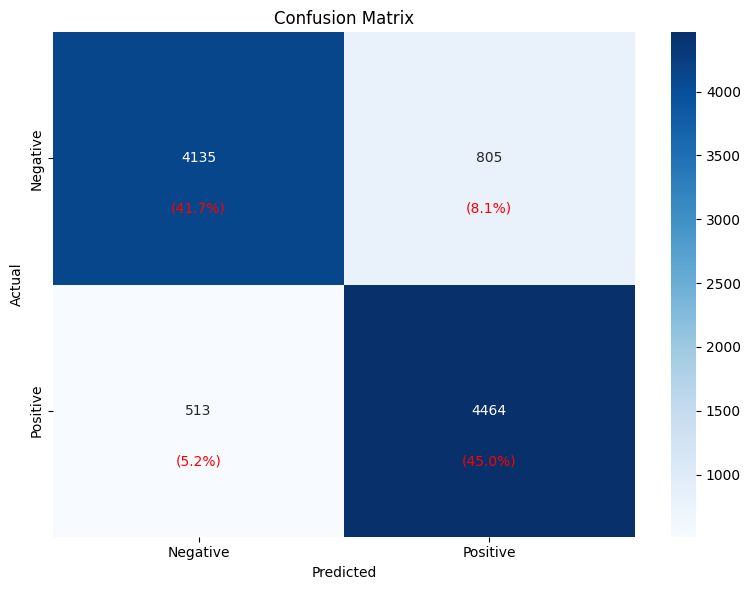


CONFUSION MATRIX ANALYSIS:
True Negatives (TN): 4135
False Positives (FP): 805
False Negatives (FN): 513
True Positives (TP): 4464
Total Samples: 9917


In [ ]:
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, f1_score

def evaluate_model_comprehensive(model, X_test, y_test):
    # Get predictions
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int).flatten()

    # Calculate metrics
    accuracy = np.mean(y_pred == y_test)
    f1 = f1_score(y_test, y_pred)
    # Import roc_auc_score from sklearn.metrics
    auc_score = roc_auc_score(y_test, y_pred_proba)

    print("MODEL EVALUATION RESULTS")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC Score: {auc_score:.4f}")
    print()

    # Classification Report
    print("CLASSIFICATION REPORT:")
    print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

    return y_pred, y_pred_proba

def plot_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Negative', 'Positive'],
                yticklabels=['Negative', 'Positive'])
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    # Add percentage annotations
    total = np.sum(cm)
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j+0.5, i+0.7, f'({cm[i,j]/total*100:.1f}%)',
                    ha='center', va='center', fontsize=10, color='red')

    plt.tight_layout()
    plt.show()

    # Print detailed confusion matrix analysis
    tn, fp, fn, tp = cm.ravel()
    print("\nCONFUSION MATRIX ANALYSIS:")
    print(f"True Negatives (TN): {tn}")
    print(f"False Positives (FP): {fp}")
    print(f"False Negatives (FN): {fn}")
    print(f"True Positives (TP): {tp}")
    print(f"Total Samples: {total}")

y_pred, y_pred_proba = evaluate_model_comprehensive(model, X_test_dl, y_test_dl)
plot_confusion_matrix(y_test_dl, y_pred)

# Impano Chretien's Model  Neural Network architecture LSTM

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# 1. Load Dataset
df = pd.read_csv('/content/IMDB Dataset.csv')

# 2. Clean and filter sentiment values
df['sentiment'] = df['sentiment'].str.strip().str.lower()
df = df[df['sentiment'].isin(['positive', 'negative'])].copy()

# 3. Tokenize and pad sequences
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(df['review'])

sequences = tokenizer.texts_to_sequences(df['review'])
X_dl = pad_sequences(sequences, maxlen=300)

# 4. Encode sentiment labels
y_dl = df['sentiment'].map({'positive': 1, 'negative': 0}).values

# 5. Train-test split
X_train_dl, X_test_dl, y_train_dl, y_test_dl = train_test_split(
    X_dl, y_dl, test_size=0.2, stratify=y_dl, random_state=42
)

# 6. Build LSTM model
lstm_model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=300),
    LSTM(128, return_sequences=False),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# 7. Compile model
lstm_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

# 8. Train model
lstm_model_history = lstm_model.fit(
    X_train_dl, y_train_dl,
    batch_size=128,
    epochs=6,
    validation_split=0.2,
    verbose=1
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 13s 26ms/step - accuracy: 0.5394 - loss: 0.6877 - val_accuracy: 0.7832 - val_loss: 0.5219
Epoch 2/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 16s 25ms/step - accuracy: 0.8335 - loss: 0.4169 - val_accuracy: 0.8731 - val_loss: 0.2971
Epoch 3/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 24ms/step - accuracy: 0.9110 - loss: 0.2364 - val_accuracy: 0.8917 - val_loss: 0.2657
Epoch 4/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - accuracy: 0.9371 - loss: 0.1824 - val_accuracy: 0.8915 - val_loss: 0.2633
Epoch 5/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - accuracy: 0.9520 - loss: 0.1473 - val_accuracy: 0.8925 - val_loss: 0.2714
Epoch 6/6
250/250 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - accuracy: 0.9673 - loss: 0.1110 - val_accuracy: 0.8907 - val_loss: 0.2866


In [ ]:
test_loss, test_acc = lstm_model.evaluate(X_test_dl, y_test_dl, verbose=1)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8895 - loss: 0.2962
Test Accuracy: 0.8891 | Test Loss: 0.2928


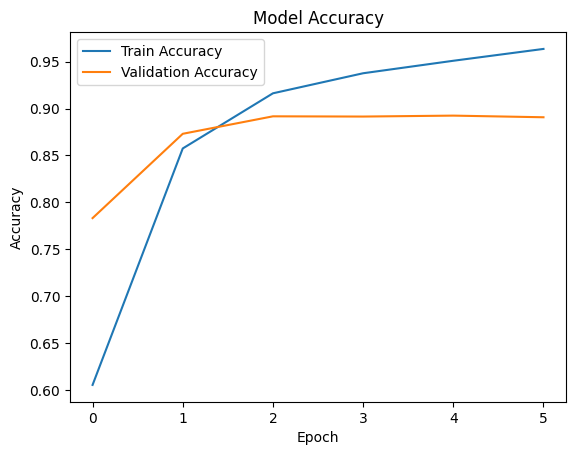

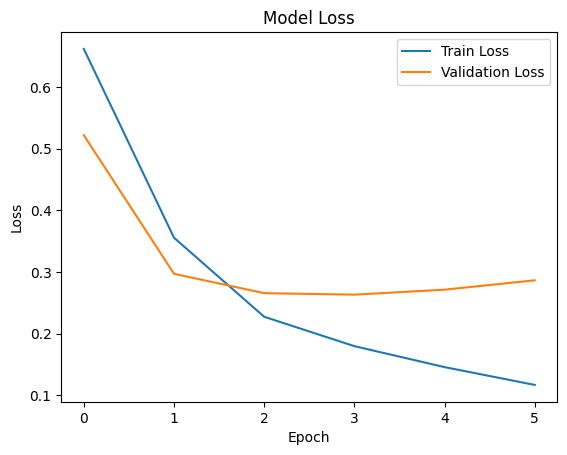

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy values
plt.plot(lstm_model_history.history['accuracy'], label='Train Accuracy')
plt.plot(lstm_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training & validation loss values
plt.plot(lstm_model_history.history['loss'], label='Train Loss')
plt.plot(lstm_model_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Denys Ntwaritaganzwa's

In [ ]:
!pip install contractions

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 23.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.3/118.3 kB 13.2 MB/s eta 0:00:00


ModuleNotFoundError: No module named 'contractions'

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/6
248/248 ━━━━━━━━━━━━━━━━━━━━ 21s 50ms/step - accuracy: 0.5340 - loss: 0.6856 - val_accuracy: 0.7984 - val_loss: 0.4685
Epoch 2/6
248/248 ━━━━━━━━━━━━━━━━━━━━ 15s 49ms/step - accuracy: 0.8391 - loss: 0.3899 - val_accuracy: 0.8608 - val_loss: 0.3458
Epoch 3/6
248/248 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.9150 - loss: 0.2395 - val_accuracy: 0.8732 - val_loss: 0.3075
Epoch 4/6
248/248 ━━━━━━━━━━━━━━━━━━━━ 21s 49ms/step - accuracy: 0.9359 - loss: 0.1878 - val_accuracy: 0.8787 - val_loss: 0.2958
Epoch 5/6
248/248 ━━━━━━━━━━━━━━━━━━━━ 12s 50ms/step - accuracy: 0.9559 - loss: 0.1443 - val_accuracy: 0.8808 - val_loss: 0.3155
Epoch 6/6
248/248 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.9647 - loss: 0.1214 - val_accuracy: 0.8804 - val_loss: 0.3543


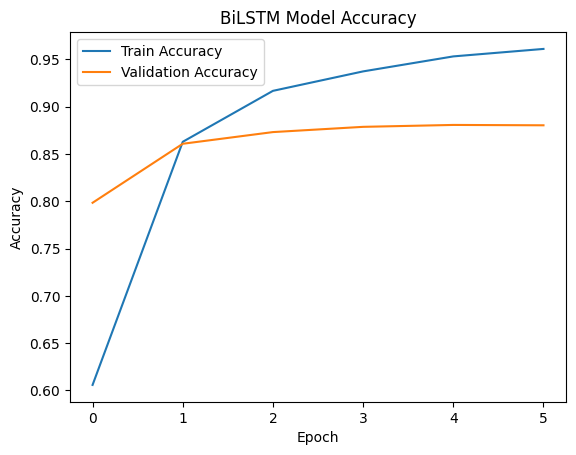

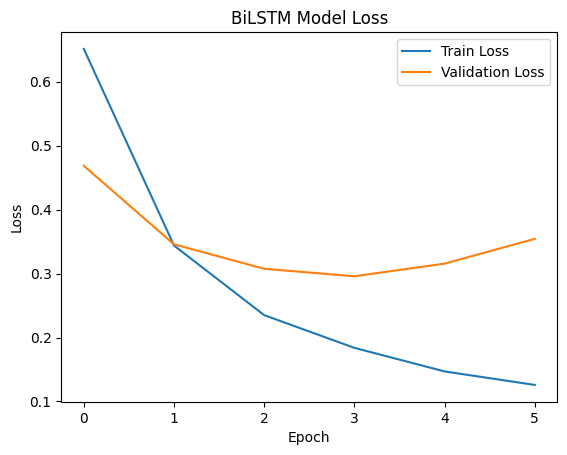

Test Accuracy: 0.8869 | Test Loss: 0.2831
310/310 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step


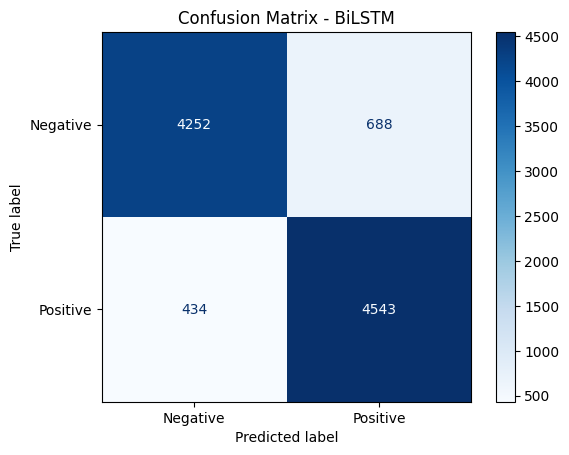

              precision    recall  f1-score   support

    Negative       0.91      0.86      0.88      4940
    Positive       0.87      0.91      0.89      4977

    accuracy                           0.89      9917
   macro avg       0.89      0.89      0.89      9917
weighted avg       0.89      0.89      0.89      9917



In [ ]:
# 1. Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


#  Build BiLSTM model
bilstm_model = Sequential([
    Embedding(input_dim=20000, output_dim=128, input_length=300),
    Bidirectional(LSTM(128, return_sequences=False)),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

#  Compile model
bilstm_model.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=1e-4), metrics=['accuracy'])

#  Train model with early stopping
early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

bilstm_model_history = bilstm_model.fit(
    X_train_dl, y_train_dl,
    batch_size=128,
    epochs=6,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

#  Plot Accuracy
plt.plot(bilstm_model_history.history['accuracy'], label='Train Accuracy')
plt.plot(bilstm_model_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('BiLSTM Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot Loss
plt.plot(bilstm_model_history.history['loss'], label='Train Loss')
plt.plot(bilstm_model_history.history['val_loss'], label='Validation Loss')
plt.title('BiLSTM Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate on test set
test_loss, test_acc = bilstm_model.evaluate(X_test_dl, y_test_dl, verbose=0)
print(f"Test Accuracy: {test_acc:.4f} | Test Loss: {test_loss:.4f}")

# Confusion Matrix
y_pred_prob = bilstm_model.predict(X_test_dl)
y_pred = (y_pred_prob > 0.5).astype(int)

cm = confusion_matrix(y_test_dl, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - BiLSTM')
plt.show()

# Classification Report
print(classification_report(y_test_dl, y_pred, target_names=['Negative', 'Positive']))
